In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate

In [2]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [4]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [200, 400, 600, 700, 800]
sigmas = [0.01, 0.3, 0.7]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [5]:
# Some UGLY but functional definitions to plot specific ns_kick values
NS_200_RANGE = [0,1,2]
NS_400_RANGE = [3,4,5]
NS_600_RANGE = [6,7,8]
NS_700_RANGE = [9,10,11]
NS_800_RANGE = [12,13,14]

SIGMA_001_RANGE = [0,3,6,9,12]
SIGMA_03_RANGE = [1,4,7,10,13]
SIGMA_07_RANGE = [2,5,8,11,14]

In [6]:
# Read model velocity data
NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"model_velocities/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)        

In [7]:
def plot_kde(PLOT_RANGE, d=2):
 
    for i in PLOT_RANGE:
        kde_NS_3D = gaussian_kde( NS_KICKS_3D[i] )
        kde_NS_2D = gaussian_kde( NS_KICKS_2D[i] )
        NS_dist_space = linspace( min(NS_KICKS_3D[i]), max(NS_KICKS_3D[i]), 100 )
        
        if d==2:
            plt.plot( NS_dist_space, kde_NS_2D(NS_dist_space), label=f'2D Projected Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');
        else:
            plt.plot( NS_dist_space, kde_NS_3D(NS_dist_space), label=f'3D Model Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [km/s ^-1]')

    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

    # plt.ylim(0, 5e-3)
    plt.xlim(0, 1200)

    plt.legend(fontsize=17)

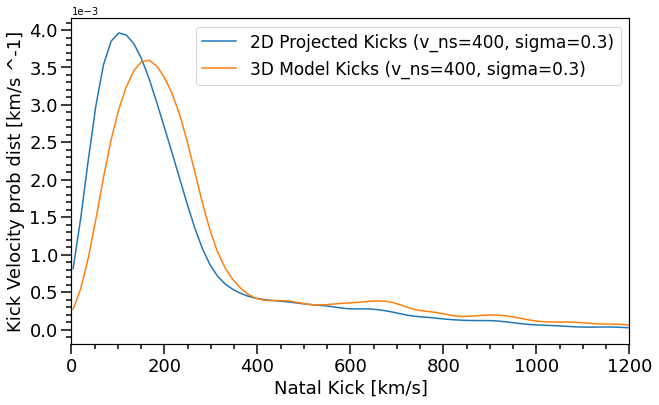

In [8]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plot_kde(np.intersect1d(NS_400_RANGE, SIGMA_03_RANGE), d=2)
plot_kde(np.intersect1d(NS_400_RANGE, SIGMA_03_RANGE), d=3)
plt.show()

# Read Likelihood Data

In [9]:
p_models = []
columns = [] # labels for plotting later
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models = p_models/np.sum(p_models)

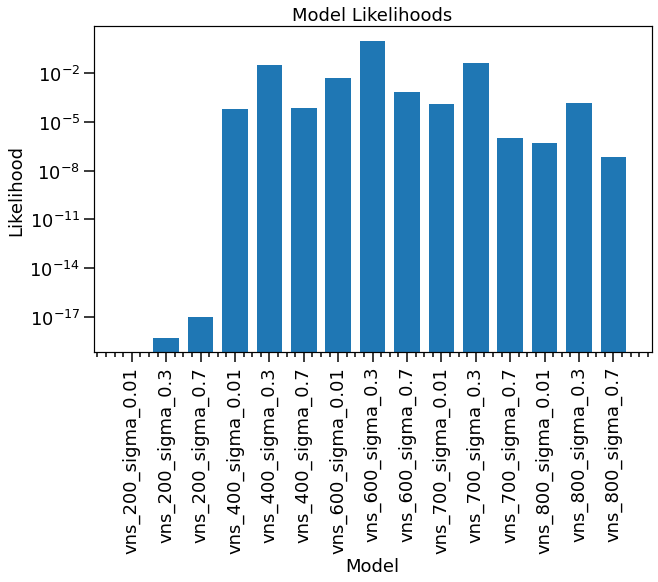

In [10]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 

x_range = np.linspace(0, len(p_models), len(p_models))
plt.bar(x_range, p_models, tick_label=columns)

layoutAxes(ax=ax, nameX='Model',\
           nameY='Likelihood')
plt.xticks(rotation=90)
plt.semilogy()

plt.title("Model Likelihoods", fontsize=18)

plt.show()

## 2D Plot

In [11]:
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

In [12]:
p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
max_num = 5 # number of max likelihoods to label

# Some code to generate labels for only the top n models
M = sorted(zip(p_models), reverse=True)[max_num - 1][0]
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels = label_f(p_models_2d)

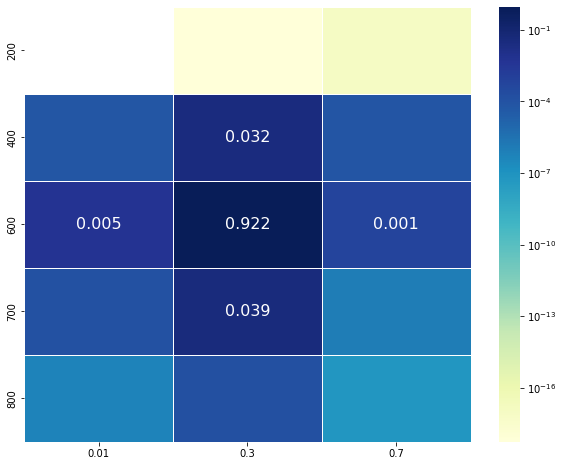

In [13]:
f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

ax = sns.heatmap(p_models_2d, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), xticklabels=sigmas, yticklabels=ns_kicks, \
                annot=labels, annot_kws={'fontsize':16}, fmt='')
plt.show()

In [14]:
# Identify the 3 most likely models
M = sorted(zip(p_models), reverse=True)[:3]
MAX_INDICES = np.where(p_models==M)[1]

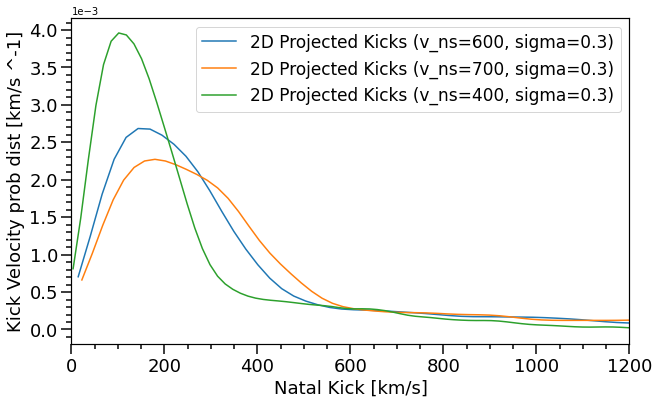

In [15]:
# The three most likely models
f, ax= plt.subplots(1, 1,  figsize=(10,6))
plot_kde(MAX_INDICES, d=2)
plt.show()

# CDF Plots

In [16]:
# Takes about 30 s
start = time.time()

vt_all = []

for file in glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'):
    vt_all.append(np.loadtxt(file, unpack=True, usecols=5))

end = time.time()
print(end - start, "s")

20.996744871139526 s


In [108]:
# index_600_03 = np.intersect1d(NS_600_RANGE, SIGMA_03_RANGE)[0]
# index_700_03 = np.intersect1d(NS_700_RANGE, SIGMA_03_RANGE)[0]
# index_400_03 = np.intersect1d(NS_400_RANGE, SIGMA_03_RANGE)[0]

In [17]:
PLOT_DATA = [vt_all, NS_KICKS_2D, NS_KICK_MULT, SIGMAS]

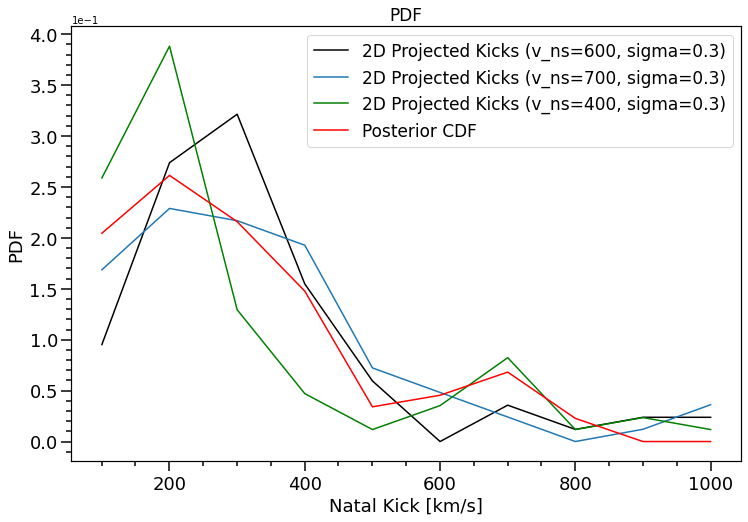

In [28]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[0], color='k')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[1], color='C0')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[2], color='g')

lpf.plot_posterior_pdf(*PLOT_DATA, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='PDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"PDF", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
# plt.semilogx()
plt.show()


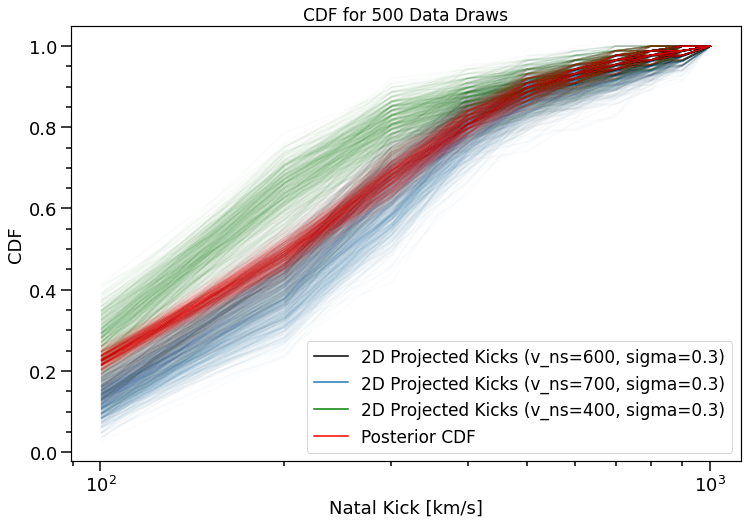

Plot completed in 22.729016 s


In [29]:
n_cdf = 500

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

start = time.time()

lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], color='k')
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], color='C0')
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], color='g')

lpf.plot_posterior_cdf(*PLOT_DATA, n_cdf, color='r')



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"CDF for {n_cdf} Data Draws", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
plt.semilogx()
plt.show()

end = time.time()
print(f"Plot completed in {end - start:2f} s")

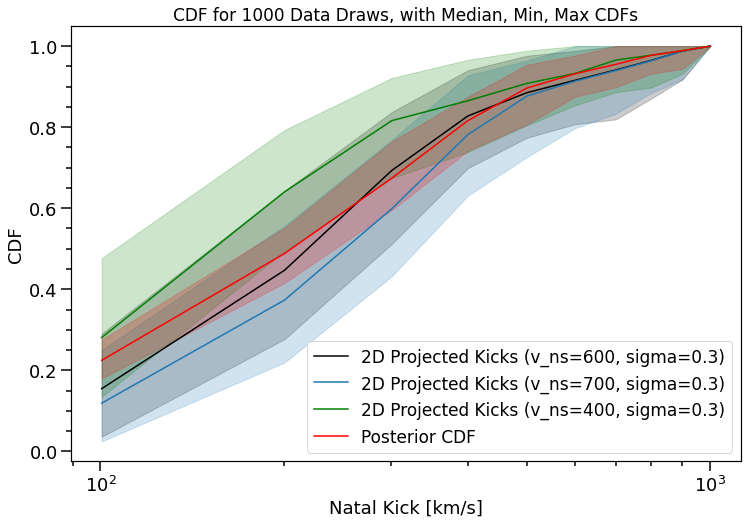

In [30]:
n_cdf = 1000
n_bins = 10

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, color='k')
lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, color='C0')
lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, color='g')


lpf.plot_avg_posterior_cdf(*PLOT_DATA, n_cdf, n_bins=n_bins, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')


plt.title(f"CDF for {n_cdf} Data Draws, with Median, Min, Max CDFs", fontsize=17)

plt.legend(fontsize=17)
    
    
plt.semilogx()
plt.show()


In [31]:
# Add up residuals
n_cdf = 100
n_bins = 10
bins, cdf_0, cdf_min, cdf_max  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins)
bins, cdf_1, cdf_min, cdf_max  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins)
bins, cdf_2, cdf_min, cdf_max  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins)

bins_posterior, cdf_posterior, cdf_min, cdf_max = lpf.get_avg_posterior_cdf(*PLOT_DATA, n_cdf, n_bins)

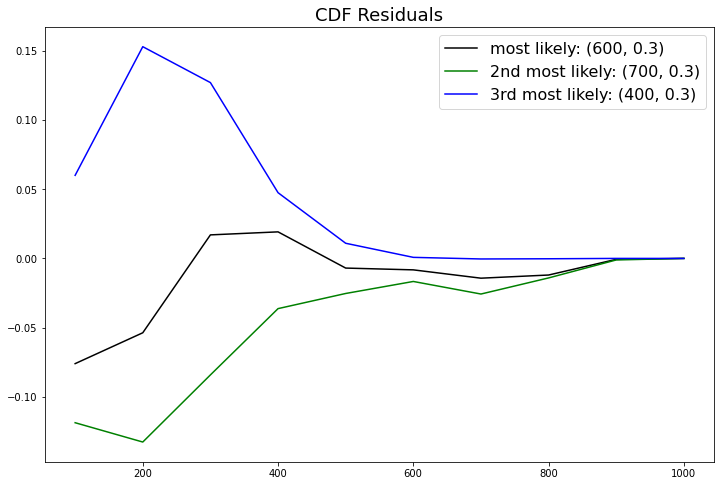

In [40]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
plt.plot(bins, cdf_0 - cdf_posterior, color='k', label=f'most likely: ({NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]})')
plt.plot(bins, cdf_1 - cdf_posterior, color='g', label=f'2nd most likely: ({NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]})')
plt.plot(bins, cdf_2 - cdf_posterior, color='b', label=f'3rd most likely: ({NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]})')
plt.title("CDF Residuals", fontsize=18)

plt.legend(fontsize=16)
plt.show()

In [41]:
print(f"Sum of residuals for {NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]} =", np.sum(np.abs(cdf_0 - cdf_posterior)))
print(f"Sum of residuals for {NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]} =", np.sum(np.abs(cdf_1 - cdf_posterior)))
print(f"Sum of residuals for {NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]} =", np.sum(np.abs(cdf_2 - cdf_posterior)))

Sum of residuals for 600, 0.3 = 0.20834974456459046
Sum of residuals for 700, 0.3 = 0.4552277957069943
Sum of residuals for 400, 0.3 = 0.400320810201649
